In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import scipy.optimize as optimize 
import scipy.fftpack as fftpack
import scipy.signal as signal 
import scipy.interpolate as interpolate
import types
import algopy
import lmfit

import mpmath

pylab.rcParams['figure.figsize'] = (15.0, 3.0)
pylab.rcParams['axes.facecolor'] = 'lightgray'
np.set_printoptions(precision=15)

# Helper functions

In [2]:
def gauss(x, mu, sigma, amplitude): 
    return amplitude * np.exp( - ((x - mu) ** 2) / (2 * (sigma**2) ))

def per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
    result = 0.0;
    for i in range(0, int((maxWl-minWl) / period)):
        result += gauss(wl, minWl + (i * period), sigma, amplitude)
    return result

# Classes that define simulated instruments.

In [3]:
class Spectrograph:
    def __init__(self, xres, bgrNoiseMu, bgrNoiseSD, minWl, maxWl, precision):
        self.xres = xres
        self.bgrNoiseMu = bgrNoiseMu
        self.bgrNoiseSD = bgrNoiseSD
        self.minWl = minWl
        self.maxWl = maxWl
        self.precision = precision
    def activate(self, lfc):
        x = np.linspace(self.minWl, self.maxWl, self.xres)
        bgrNoise = np.random.normal(self.bgrNoiseMu, self.bgrNoiseSD, len(x)) # Background noise
        bgrNoise[bgrNoise < 0.0] = 0.0

        # Lfc
        lfcReading = lfc.simulate(x) # LFC
        # Also add shot noise. Noise is proportional to the square root of the intensity
        lfcReading[lfcReading == 0.00] = 0.001
        # This should be poisson because poisson is discrete, but it doesnt really matter, just call floor
        shotNoise = np.random.normal(0, np.sqrt(lfcReading) * self.precision / 2, len(x))
        lfcReading += shotNoise

        # Overlap inputs by adding to y
#         y = bgrNoise + lfcReading
        y = lfcReading
        return np.linspace(0, self.xres, self.xres), y

class LFC:
    def __init__(self, intensity, fhwm, minWl, maxWl, dWl):
        self.intensity = intensity
        self.sigma = fhwm / (2 * np.sqrt(2 * np.log(2))) # sd = fhwm / 2sqrt(2ln2)
        self.minWl = minWl
        self.maxWl = maxWl
        self.span = self.maxWl - self.minWl
        self.dWl = np.float64(dWl)
    def getPeaks(self):
        peaks = np.empty(0)
        current = self.minWl;
        while(current < self.maxWl):
            peaks = np.append(peaks, current)
            current += self.dWl
        return peaks
    def simulate(self, wlSpace):
        y = per_gauss(wlSpace, self.sigma, self.minWl, self.maxWl, self.dWl, self.intensity)
        return y

# Simulating the LFC

~~**Method 1**: Getting a comb by convolving the result of a gaussian and a delta function on the same linear space. Note that the result convolution is a set of points, not a function. Need high initial resolution to then use this as a 'real world' baseline.~~

In [4]:
# x = np.arange(-1, 1, 0.001)
# y_gauss = vgauss(x, 0, 0.01, 1)

# # The world's resolution
# res = 30000
# y_delta = np.repeat(0, res)
# for i in range(0, len(y_delta)):
#      if (i % (res * lfc.dWl / lfc.span)) == 0:
#          y_delta[i] = 1
# conv = np.convolve(y_gauss, y_delta, 'same')
# plt.scatter(np.linspace(lfc.minWl, lfc.maxWl, res), conv)
# # plt.xlim(400, 450)
# pylab.rcParams['figure.figsize'] = (15.0, 2.0)
# plt.show()

**Method 2**: Adding a series of gaussians together to simulate a comb. Current implementation of the LFC class (Code is now part of the LFC class).

# Finding maxima

~~**Method 1**: Fitting |tan(x)|~~

In [5]:
# def absTan(x, a, b):
#     return np.absolute(a * np.tan(b * x))
    
# x, y = sgraph.activate(lfc)
# # plt.scatter(x, y)
# # print(x)
# # print(np.tan(x))
# popt, pcov = optimize.curve_fit(absTan, x, y, p0=[5, 10])
# y_fitted = absTan(x, popt[0], popt[1])

# # x = np.linspace(400, 410, 7000)
# # y = absTan(x, 1, 3)
# # plt.plot(x, y, color='red')

# plt.plot(x, y_fitted, color='red')
# plt.scatter(x, y)

# plt.xlim(400, 410)
# plt.show()

~~**Method 2**: Fitting a Fourier series~~

In [6]:
# x, y = sgraph.activate(lfc)
# filter = y > 1 # Have to pick some threshold!
# x_filtered = x[filter]
# y_filtered = y[filter]

# spec = fftpack.dct(y_filtered, norm='ortho', n=len(x_filtered))
# # spec = np.fft.fft(y_filtered, norm='ortho', n=len(x_filtered))

# # freqs = fftpack.fftfreq(len(y_filtered))
# # maxFreq = freqs[maxFreqIdx]
# # print(maxFreqIdx)
# # print(maxFreq)
# # print('max period is: ', 1/maxFreq)

# maxFreqIdx = np.argmax(np.abs(spec[1:])) + 1
# plt.plot(spec)
# plt.scatter(maxFreqIdx, 50)
# plt.show()

# fitted_y = fftpack.idct(spec, norm='ortho', n=len(x_filtered))
# # fitted_y = np.fft.ifft(spec[0:50], norm='ortho', n=len(x_filtered))

# plt.scatter(x_filtered, y_filtered)
# plt.plot(x_filtered, fitted_y, color='red')
# # plt.xlim(400, 405)
# # plt.ylim(1, 1.4)

# extrema = signal.argrelextrema(fitted_y, np.greater, order=5)
# x_ext = x_filtered[extrema[0]]
# y_ext = fitted_y[extrema]
# plt.scatter(x_ext, y_ext, color='green')

# plt.show()

**Method 3:** Fitting a periodic gaussian

In [7]:
# Deprecated fitting code
# Fit using curve_fit
# popt, pcov = optimize.curve_fit(per_gauss_fit, ss_x, ss_y, p0=[guess_x], sigma=np.sqrt(ss_y), ftol=1e-12, xtol=1e-12, epsfcn=0.0)

# Fit using leastsq
# err_func = lambda tpl,x,y: (per_gauss_fit(x, tpl) - y)
# #     def jac_errfunc(p, t, y):
# #         ap = algopy.UTPM.init_jacobian(p)
# #         return algopy.UTPM.extract_jacobian(err_func(ap, t, y))
# #     popt, pcov, info = optimize.leastsq(err_func, [guess_x], Dfun=jac_errfunc, args=(ss_x, ss_y), xtol=1e-12, ftol=1e-12, maxfev=1000 * (len(ss_x) + 1))
# popt, pcov, info, msg, success = optimize.leastsq(err_func, [guess_x], args=(ss_x, ss_y), full_output=1, xtol=1e-20, ftol=1e-20, maxfev=1000*(len(ss_x) + 1))
# nfev = info['nfev']
# pred_shift = popt[0]
# y_pred = per_gauss_fit(ss_x, *popt)

# Fit using Brent
# err_func = lambda shift: np.mean(np.abs(per_gauss_fit(ss_x, shift) - ss_y))
# result = optimize.minimize_scalar(err_func, method='Brent', bracket=(guess_x-5, guess_x+5), tol=1e-15)
# nfev = result.nit
# pred_shift = result.x
# y_pred = per_gauss_fit(ss_x, pred_shift)

# Approx with curve_fit
# popt, pcov = optimize.curve_fit(per_gauss_fit, ss_x, ss_y, p0=[guess_x], sigma=np.sqrt(ss_y), ftol=1e-12, xtol=1e-12, epsfcn=0.0)
# second_guess_x = popt[0]
# print('Second guess is:', second_guess_x)

# ####
# Approx with lmfit
# ss_x = ss_x[ss_y > 4000]
# ss_y = ss_y[ss_y > 4000]
# gmod = lmfit.Model(per_gauss_fit)
# result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='lbfgsb', 
#                   options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'factr':10.0, 'disp':True, 
#                            'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
# print('lbfgsb executed # times:', result.nfev)
# second_guess_x = result.params['minWl'].value
# print('Second guess is:', second_guess_x)
# temp_pred = per_gauss_fit(ss_x, second_guess_x)
# lse = np.mean(np.abs(ss_y - temp_pred))
# print('Second guess lse is ' + str(lse))

# solution = (lfc.minWl - sgraph.minWl) * fac
# print('Solution is:', solution)
# temp_pred = per_gauss_fit(ss_x, solution)
# lse = np.mean(np.abs(ss_y - temp_pred))
# print('lse of optimap solution is ' + str(lse))

# # Fit using brute
# err_func = lambda shift: np.mean(np.abs(per_gauss_fit(ss_x, shift) - ss_y))
# result = optimize.brute(err_func, ranges=((second_guess_x-1e-3, second_guess_x+1e+3),), Ns=100, full_output=True, finish=None)
# nfev = 0
# pred_shift = result[0]
# y_pred = per_gauss_fit(ss_x, pred_shift)
# #####

# eps = np.finfo(np.float64).eps
# err_func = lambda tpl,x,y: (per_gauss_fit(x, tpl) - y)
# result = optimize.least_squares(err_func, [guess_x], args=(ss_x, ss_y), xtol=eps, ftol=eps, gtol=eps,
#                                 max_nfev=1000 * (len(ss_x) + 1), method='dogbox')
# popt = result.x
# pred_shift = popt[0]
# nfev = result.nfev
# y_pred = per_gauss_fit(ss_x, *popt)
# print('Terminated because: ' + result.message)


In [8]:
def pix_to_wl(pix, sgraph):
    fac = sgraph.xres / (sgraph.maxWl - sgraph.minWl)
    return sgraph.minWl + (pix / fac)
    
def wl_to_pix(wl, sgraph):
    fac = sgraph.xres / (sgraph.maxWl - sgraph.minWl)
    return (wl - sgraph.minWl) * fac
    
def get_peaks(shift, lfc, n):
    peaks = np.empty(0)
    current = shift
    for i in range(0, n):
        peaks = np.append(peaks, current)
        current += lfc.dWl
    return peaks
    
def pred_error(y, pred_y, solution, prediction):
    lse = np.mean(np.abs(y - pred_y))
    error = np.abs(solution - prediction) / solution * 3e8
    return lse, error
    
def guess_min(x, y):
    guess_x = x[y > 2000]
    guess_y = y[y > 2000]
    max_idx = signal.argrelextrema(guess_y, np.greater, order=10)
    guess_max_x = guess_x[max_idx]
    guess_max_y = guess_y[max_idx]
    guess_x = guess_max_x[0]
    guess_y = guess_max_y[0]
    return guess_x, guess_y
    
def find_lfc_peaks(sgraph, lfc):
    fac = sgraph.xres / (sgraph.maxWl - sgraph.minWl)
    lfc_peaks = lfc.getPeaks()
    
    def per_gauss_fit(wl, minWl):
        return per_gauss(wl, lfc.sigma * fac, minWl, minWl + ((len(lfc_peaks) - 1) * lfc.dWl * fac), lfc.dWl * fac, lfc.intensity)
    
    print('Solution is: {}pix or {}nm'.format(wl_to_pix(lfc.minWl, sgraph), lfc.minWl))

    x, y = sgraph.activate(lfc)
    
    # Do a cubic interpolation of x and y 
    spl = interpolate.UnivariateSpline(x, y, k=3)
    # ss stands for supersampled
    ss_x = np.linspace(0, sgraph.xres, 20000, dtype=np.float64)
    ss_y = spl(ss_x)
#     ss_x = x
#     ss_y = y
    ss_y[ss_y <= 0.0] = 1e-15
    
    # Fit on interpolated data
    guess_x, guess_y = guess_min(ss_x, ss_y)
    print('Initial guess for shift is: {}pix or {}nm'.format(np.asarray([guess_x]), pix_to_wl(guess_x, sgraph)))
    
    # Use lmfit for fitting
    gmod = lmfit.Model(per_gauss_fit)
    result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='lbfgsb', 
                      options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(ss_x) + 1), 'factr':1.0, 'disp':True, 
                               'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
#     result = gmod.fit(ss_y, wl=ss_x, minWl=guess_x, method='leastsq', 
#                       options={'disp': True, 'xtol': 1e-20, 'ftol': 1e-20, 'maxiter':20000000, 'maxfev':200000})
    pred_shift = result.params['minWl'].value
    y_pred = result.best_fit
    nfev = result.nfev
    pred_shift_wl = pix_to_wl(pred_shift, sgraph)
    print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift]), pred_shift_wl))
    print('Number of calls: {}'.format(nfev))
    
    pred_peaks = get_peaks(pred_shift_wl, lfc, len(lfc_peaks))
    
    print(lfc_peaks[0:3], lfc_peaks[-3:])
    print(pred_peaks[0:3], pred_peaks[-3:])
    
    lse, error = pred_error(ss_y, y_pred, lfc.minWl, pred_shift_wl)
    print('Least squares error is {}'.format(lse))
    print('Error is: {}m/s'.format(error))
    
    lse, error = pred_error(y, per_gauss_fit(x, wl_to_pix(lfc.minWl, sgraph)), lfc.minWl, pred_shift_wl)
    print('Best squares error is {}'.format(lse))
    
    plt.scatter(ss_x, ss_y, color='blue')
    plt.scatter(x, y, color='magenta')
    plt.plot(ss_x, y_pred, color='red')
    for peak in pred_peaks:
        plt.axvline((peak - sgraph.minWl) * fac, color='green')
    for peak in lfc_peaks:
        plt.axvline((peak - sgraph.minWl) * fac, color='purple')
    plt.axvline(guess_x, color='turquoise')
    plt.xlim(guess_x - 3 * (lfc.dWl * fac), guess_x + 12 * (lfc.dWl * fac))
#     plt.xlim(wl_to_pix(lfc.maxWl, sgraph) - 12 * (lfc.dWl * fac), wl_to_pix(lfc.maxWl, sgraph) + 3 * (lfc.dWl * fac))
    fig = plt.show()
    
    return ss_x, ss_y, pred_shift

In [9]:
rand = np.random.random(1)[0]
lfc = LFC(250000, 0.0075, 400 + rand, 410 + rand, 1.0/31.0)
sgraph = Spectrograph(4000, 1000.0, 300.0, 399.0, 411.0, 1.0)

# Notes
- Create plot of jitter to error
- Resolution = wl of order / (wl to pix ratio) -> 400 / 0.025
- 80 orders [pix, intens, order]
- Further away orders are distorted
- Should use adjacent order


- Generate plots of SNR to error in cm/s
    - Moving Sigma from 2 to 4, R from 50,000 to 20,0000
    
- Paper submission to PASP


In [10]:
x, y = sgraph.activate(lfc)

Solution is: 612.15491507pix or 400.836464745nm
Initial guess for shift is: [ 612.230611530576539]pix or 400.836691835nm
 - Adding parameter "minWl"
Predicted shift is: [ 612.154920862547215]pix or 400.836464763nm
Number of calls: 91
(array([ 400.836464745209696,  400.868722809725853,  400.900980874242009]), array([ 410.739690551669753,  410.771948616185909,  410.804206680702066]))
(array([ 400.836464762587639,  400.868722827103795,  400.900980891619952]), array([ 410.739690569047696,  410.771948633563852,  410.804206698080009]))
Least squares error is 776.711516702
Error is: 0.013006258788m/s
Best squares error is 389.008430783


/usr/lib/python2.7/site-packages/lmfit/model.py:459: UserWarning: The keyword argument options does notmatch any arguments of the model function.It will be ignored.
  "It will be ignored.", UserWarning)


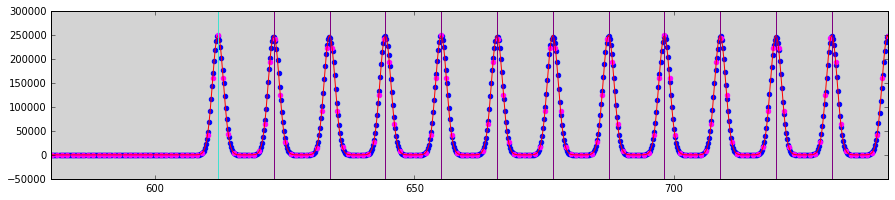

CPU times: user 21 s, sys: 0 ns, total: 21 s
Wall time: 20.9 s


In [11]:
%%time
ss_x, ss_y, pred_shift = find_lfc_peaks(sgraph, lfc)

Solution is: 499.965308839pix or 400.499895927nm
 - Adding parameter "shift"
Predicted shift is: [ 499.965972474730449]pix or 400.499897917nm
Number of calls: 15
Least squares error is 1003.69705345
Error is: 1.49131613724m/s
Best squares error is 1003.70438053


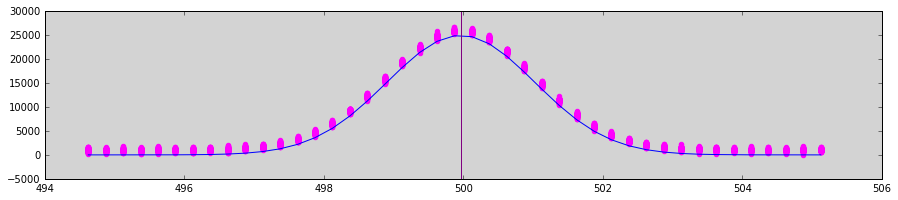

In [38]:
def rofl(sgraph, lfc):
    fac = sgraph.xres / (sgraph.maxWl - sgraph.minWl)
    def gauss_fit(wl, shift): 
        return lfc.intensity * np.exp( - ((wl - shift) ** 2) / (2 * ((lfc.sigma * fac)**2) ))
    
    print('Solution is: {}pix or {}nm'.format(wl_to_pix(lfc.minWl, sgraph), lfc.minWl))
    lfc_peaks = lfc.getPeaks()
    x, y = sgraph.activate(lfc)
    guess_x, guess_y = guess_min(x, y)
    
    # Add interpolated points
#     spl = interpolate.UnivariateSpline(x, y, k=3)
#     # ss stands for supersampled
#     x = np.linspace(0, sgraph.xres, 20000, dtype=np.float64)
#     y = spl(x)
    y[y <= 0.0] = 1e-15
    
    # Fold all points into first peak
    ranges = []
    current = 0.0
    for i in range(0, len(lfc_peaks)):
        pix_peak = wl_to_pix(lfc_peaks[i], sgraph)
        prev = current
        current = pix_peak + (lfc.dWl * fac / 2)
        selection = np.nonzero((x < current) & (x > prev))
        x[selection] = x[selection] - (i * lfc.dWl * fac)
        ranges.append(pix_peak + (lfc.dWl * fac / 2))
        
    # Chop off left tail
    selection = (x > (ranges[0] - (lfc.dWl * fac)))
    x = x[selection]
    y = y[selection]
    
    # Chop off right
    selection = (x < (ranges[len(ranges) - 1]))
    x = x[selection]
    y = y[selection]
    
    sorted = x.argsort()
    x = x[sorted]
    y = y[sorted]
    
    # Fit single gaussian
    gmod = lmfit.Model(gauss_fit)
    result = gmod.fit(y, wl=x, shift=guess_x, method='lbfgsb', 
                      options={'ftol':1e-20, 'gtol':1e-20, 'maxiter':20000*(len(x) + 1), 'factr':1.0, 'disp':True, 
                               'eps':np.finfo(np.float64).eps, 'maxls':100, 'maxfun':100000, 'maxcor':100})
#     result = gmod.fit(y, wl=x, shift=guess_x, method='leastsq', 
#                       options={'disp': True, 'xtol': 1e-20, 'ftol': 1e-20, 'maxiter':20000000, 'maxfev':200000})
    pred_shift = result.params['shift'].value
    y_pred = result.best_fit
    nfev = result.nfev
    pred_shift_wl = pix_to_wl(pred_shift, sgraph)
    print('Predicted shift is: {}pix or {}nm'.format(np.asarray([pred_shift]), pred_shift_wl))
    print('Number of calls: {}'.format(nfev))
    
    lse, error = pred_error(y, y_pred, lfc.minWl, pred_shift_wl)
    print('Least squares error is {}'.format(lse))
    print('Error is: {}m/s'.format(error))
    
    lse, error = pred_error(y, gauss_fit(x, wl_to_pix(lfc.minWl, sgraph)), lfc.minWl, pred_shift_wl)
    print('Best squares error is {}'.format(lse))
        
    
    # Draw plot
    plt.scatter(x, y, color='magenta')
    plt.plot(x, y_pred, color='blue')
    first_peak = wl_to_pix(lfc.minWl, sgraph)
    plt.axvline(pred_shift, color='green')
    plt.axvline(wl_to_pix(lfc.minWl, sgraph), color='purple')
    
#     for i in ranges:
#         plt.axvline(i, color='purple')
#     plt.xlim(first_peak - 3 * (lfc.dWl * fac), first_peak + 10 * (lfc.dWl * fac))
#     plt.xlim(pred_shift - 1, pred_shift + 1)
    fig = plt.show()

rand = np.random.random(1)[0]
lfc = LFC(25000, 0.0075, 400 + rand, 410 + rand, 1.0/31.0)
sgraph = Spectrograph(4000, 1000.0, 300.0, 399.0, 411.0, 1.0)
rofl(sgraph, lfc)

(array([  1.000000000000000e+00,   0.000000000000000e+00,
          0.000000000000000e+00,   0.000000000000000e+00,
          1.000000000000000e+00,   3.000000000000000e+00,
          2.000000000000000e+00,   0.000000000000000e+00,
          1.000000000000000e+00,   0.000000000000000e+00,
          1.000000000000000e+00,   0.000000000000000e+00,
          2.000000000000000e+00,   1.000000000000000e+00,
          0.000000000000000e+00,   1.000000000000000e+00,
          0.000000000000000e+00,   1.000000000000000e+00,
          4.000000000000000e+00,   0.000000000000000e+00,
          4.000000000000000e+00,   2.000000000000000e+00,
          3.000000000000000e+00,   3.000000000000000e+00,
          5.000000000000000e+00,   6.000000000000000e+00,
          4.000000000000000e+00,   7.000000000000000e+00,
          4.000000000000000e+00,   9.000000000000000e+00,
          1.100000000000000e+01,   1.400000000000000e+01,
          1.100000000000000e+01,   1.900000000000000e+01,
          1.80

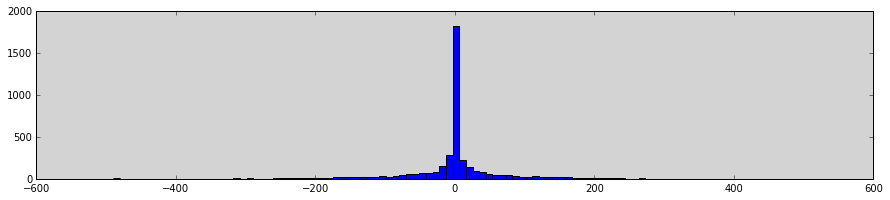

In [96]:
lfc = LFC(25000, 0.0075, 400 + rand, 410 + rand, 1.0/31.0)
sgraph = Spectrograph(4000, 1000.0, 300.0, 399.0, 411.0, 1.0)
x = np.linspace(sgraph.minWl, sgraph.maxWl, sgraph.xres)
lfcReading = lfc.simulate(x, lfc.sigma, lfc.minWl, lfc.maxWl, lfc.dWl, lfc.intensity)
lfcReading[lfcReading == 0.00] = 0.00000001
data = np.random.normal(0, np.sqrt(lfcReading) * sgraph.precision, len(x))
plt.hist(data, bins=99)

In [ ]:
fac = np.float64(sgraph.xres) / (sgraph.maxWl - sgraph.minWl)
def per_gauss_fit(wl, minWl):
    return per_gauss(wl, lfc.sigma * fac, minWl, minWl + (lfc.nPeaks * lfc.dWl * fac), lfc.dWl * fac, lfc.intensity)
    
# Trying to improve result manually
adj = -7e-6
new_pred_shift = pred_shift + (adj * fac)
new_y_pred = per_gauss_fit(ss_x, new_pred_shift)

new_lse = np.mean(np.abs(ss_y - new_y_pred))

# Recalculate peaks
pred_peaks = np.empty(0)
current = sgraph.minWl + (new_pred_shift / fac)
for i in range(0, len(peaks)):
    pred_peaks = np.append(pred_peaks, current)
    current += lfc.dWl
new_error = np.mean(np.abs((peaks - pred_peaks) / peaks)) * 3e8
        
print(pred_peaks[0:3], pred_peaks[-3:])
print(peaks[0:3], peaks[-3:])

    
print('New least squares error is ' + str(new_lse))
print('Old least squares error is ' + str(lse))

print('New error is: ' + str(abs(new_error)))
print('Old error is: ' + str(abs(error)))



# Let's try this for spectrographs with varying precision

In [ ]:
for i in range(1, 11):
    precision = i * 2
    cur_sgraph = Spectrograph(4000, 1000, 300, 399, 411, precision)
    find_lfc_peaks(cur_sgraph, lfc)


# Enter mpmath

In [ ]:
def gauss(x, mu, sigma, amplitude): 
    return amplitude * np.exp( - ((x - mu) ** 2) / (2 * (sigma**2) ))

def per_gauss(wl, sigma, minWl, maxWl, period, amplitude):
    result = 0.0;
    for i in range(0, int((maxWl-minWl) / period)):
        result += gauss(wl, minWl + (i * period), sigma, amplitude)
    return result

fac = sgraph.xres / (sgraph.maxWl - sgraph.minWl)
print('fac is:', np.asarray([fac]))
def per_gauss_fit(wl, minWl):
    return per_gauss(wl, lfc.sigma * fac, minWl, minWl + (len(peaks) * lfc.dWl * fac), lfc.dWl * fac, lfc.intensity)

x, y = sgraph.activate(lfc)
    

# Notes
- Spectrograph error distribution: what is a good mean and a mean sdev?
- Doing least squares: should I weight according to error? For example, know error increases with intensity

**For future**:
- Oversample using interpolation (--??--), play with this only
- Shift data by some random number

- Make a table of effect of increasing the lfc